In [1]:
import datetime as dt
import logging
import os

import arviz as az
import numpy as np
import numpyro
import pandas as pd
import torch
import xarray as xr
from dateutil.relativedelta import relativedelta
from matplotlib import pyplot as plt
from mizani.breaks import date_breaks
from mizani.formatters import date_format
from plotnine import (
    aes,
    geom_line,
    facet_grid,
    geom_ribbon,
    ggplot,
    scale_x_datetime,
    theme_bw,
    xlab,
    ylab,
    theme,
    element_text
)
from sklearn.gaussian_process import kernels
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import TimeSeriesSplit

from src.data_loading.data_loading import load_data
from src.preprocessing.preprocessing import XArrayStandardScaler, SeasonalFeatures, XArrayFeatureUnion
from src.modeling.ensemble import DefaultEnsemble, BaggedXArrayRegressor, BoostedRegressor, RandomForest
from src.modeling.gaussian_process import SklearnGPModel, LaggedSklearnGP, MultitaskGP
from src.modeling.var_models import VAR, NARX
from src.modeling.lm import LinearModel
from src.modeling.metrics import summarize
from src.utils import create_rnbs_snapshot, flatten_array

logging.basicConfig(level=logging.INFO)

# device = "cuda"
device = "cpu"
torch.set_default_device(device)

os.environ["JAX_PLATFORM_NAME"] = device

numpyro.set_platform(device)
numpyro.set_host_device_count(4 if device == "cpu" else 1)

In [2]:
lake_data = (load_data(["rnbs", "precip", "temp", "evap"]).
             sel(type="Basin").
             dropna("Date").
             to_array().
             transpose("Date", "lake", ...)
             )
lake_data

<xarray.DataArray (Date: 384, lake: 4, variable: 4)>
array([[[-20.92372 ,  24.8     , 266.2     ,  29.08    ],
        [ 40.5714  ,  42.78    , 266.3     ,  40.95    ],
        [ 93.83467 ,  13.33    , 258.3     ,  57.94    ],
        [239.5306  ,  46.5     , 526.5     ,  89.74    ]],

       [[ 33.66357 ,  14.56    , 263.9     ,  24.95    ],
        [ 39.75065 ,  16.8     , 261.1     ,  35.42    ],
        [145.7005  ,  16.8     , 258.4     ,  34.3     ],
        [ 92.36002 ,  24.92    , 522.4     ,  68.1     ]],

       [[139.9274  ,  28.21    , 274.2     ,  29.88    ],
        [234.0305  ,  22.32    , 274.2     ,  32.27    ],
        [278.341   ,  35.03    , 267.1     ,  35.06    ],
        [446.8436  ,  68.2     , 541.7     ,  59.49    ]],

       ...,

       [[-34.00105 ,  18.29    , 285.3     ,  55.55    ],
        [-47.44791 ,  23.25    , 283.6     ,  62.46    ],
        [-45.33585 ,  19.84    , 280.5     ,  53.57    ],
        [116.2634  ,  32.24    , 566.2     , 120.5     ]],

       [[  3.796643,  27.6     , 278.5     ,  37.59    ],
        [-13.97484 ,  26.7     , 277.3     ,  45.81    ],
        [-10.20312 ,  25.2     , 274.1     ,  54.42    ],
        [142.3357  ,  37.5     , 553.3     , 100.35    ]],

       [[-53.29011 ,  16.12    , 269.9     ,  42.62    ],
        [ -2.97982 ,  28.83    , 269.4     ,  53.72    ],
        [  0.      ,  13.64    , 266.5     ,  59.74    ],
        [173.6947  ,  35.34    , 538.      , 114.91    ]]])
Coordinates:
  * Date      (Date) datetime64[ns] 1979-01-01 1979-02-01 ... 2010-12-01
  * lake      (lake) object 'sup' 'mic_hur' 'eri' 'ont'
    type      <U5 'Basin'
  * variable  (variable) object 'rnbs' 'precip' 'temp' 'evap'
Attributes:
    source:   GLCC

In [3]:
num_splits = 12
forecast_steps = 12
splitter = TimeSeriesSplit(n_splits=num_splits, test_size=forecast_steps)

splits = list(splitter.split(lake_data))

X, y = lake_data.sel(variable=["precip", "temp", "evap"]).drop("type"), lake_data.sel(variable=["rnbs"]).squeeze().drop(
    ["type", "variable"])

y = XArrayStandardScaler().fit_transform(y)
X, y


(<xarray.DataArray (Date: 384, lake: 4, variable: 3)>
 array([[[ 24.8 , 266.2 ,  29.08],
         [ 42.78, 266.3 ,  40.95],
         [ 13.33, 258.3 ,  57.94],
         [ 46.5 , 526.5 ,  89.74]],
 
        [[ 14.56, 263.9 ,  24.95],
         [ 16.8 , 261.1 ,  35.42],
         [ 16.8 , 258.4 ,  34.3 ],
         [ 24.92, 522.4 ,  68.1 ]],
 
        [[ 28.21, 274.2 ,  29.88],
         [ 22.32, 274.2 ,  32.27],
         [ 35.03, 267.1 ,  35.06],
         [ 68.2 , 541.7 ,  59.49]],
 
        ...,
 
        [[ 18.29, 285.3 ,  55.55],
         [ 23.25, 283.6 ,  62.46],
         [ 19.84, 280.5 ,  53.57],
         [ 32.24, 566.2 , 120.5 ]],
 
        [[ 27.6 , 278.5 ,  37.59],
         [ 26.7 , 277.3 ,  45.81],
         [ 25.2 , 274.1 ,  54.42],
         [ 37.5 , 553.3 , 100.35]],
 
        [[ 16.12, 269.9 ,  42.62],
         [ 28.83, 269.4 ,  53.72],
         [ 13.64, 266.5 ,  59.74],
         [ 35.34, 538.  , 114.91]]])
 Coordinates:
   * Date      (Date) datetime64[ns] 1979-01-01 1979-02-01 .

In [6]:
preprocessor = XArrayFeatureUnion([
    ("preprocess", Pipeline(steps=[
        ("scale", XArrayStandardScaler()),
        ("flatten", FunctionTransformer(flatten_array))
    ])),
    ("seasonal", SeasonalFeatures())
])

gp_models = {
    "GP_Matern": Pipeline(steps=[("preprocessor", preprocessor),
                                 ("model", SklearnGPModel(
                                     1.0 * kernels.Matern(
                                         nu=1.5) * kernels.RationalQuadratic()
                                 ))
                                 ]),
    "GP_MaternLag": Pipeline(steps=[("preprocessor", preprocessor),
                                    ("model", LaggedSklearnGP(
                                        1.0 * kernels.Matern(
                                            nu=1.5) * kernels.RationalQuadratic()
                                    ))
                                    ]),
    "MultitaskGP": Pipeline(steps=[
        ("preprocess", preprocessor),
        ("model", MultitaskGP(epochs=100))
    ]),
}

simple_models = {
    "SimpleLM": Pipeline(steps=[
        ("preprocess", preprocessor),
        ("model", LinearModel())
    ]),
    "RF": Pipeline(steps=[
        ("preprocess", preprocessor),
        ("model", RandomForest())
    ]),
    "BoostedTrees": Pipeline(steps=[
        ("preprocess", preprocessor),
        ("model", BoostedRegressor(n_estimators=1000))
    ]),
}

varx_models = {
    "NARX": Pipeline(steps=[
        ("preprocess", XArrayStandardScaler()),
        (
            "model",
            NARX(lags={"y": 3, "temp": 2, "precip": 2, "evap": 3}, num_warmup=3000, num_chains=4, num_samples=1000)
        )
    ]),
    "VARX": Pipeline(steps=[
        ("preprocess", XArrayStandardScaler()),
        (
            "model",
            VAR(lags={"y": 3, "precip": 2, "temp": 2, "evap": 3}, num_warmup=1000, num_chains=4, num_samples=1000)
        )
    ]),

}

# use only temp and precip
all_models = {
    "Default": Pipeline(steps=[("preprocessor", preprocessor), ("model", DefaultEnsemble())]),
    **simple_models,
    **gp_models,
    **varx_models,
}



In [7]:
# for name, model in all_models.items():
train_id, test_id = splits[0]

# run cross validated
results = []
for name, model in all_models.items():
    logging.info(f"Fitting {name} model...")
    for i, (train_id, test_id) in enumerate(splits):
        logging.info(f"Fitting {name} model (split {i + 1}/{num_splits})")
        # X[train_id], y[train_id]
        model.fit(X[train_id], y[train_id])
        preds = model.predict(X[:max(test_id) + 1], y=y[:max(test_id) + 1], forecast_steps=forecast_steps)

        array = xr.concat([
            preds,
            y[test_id].expand_dims({"value": ["true"]}, axis=-1)
        ], dim="value")

        predictions = pd.concat([
            arr.to_pandas().assign(months_ahead=list(range(1, forecast_steps + 1)), model=name)
            for arr in array.transpose("lake", ...)
        ], axis=0, keys=preds.lake.values, names=["lake"])
        results.append(predictions)

cv_results = pd.concat(results, axis=0)


INFO:root:Fitting Default model...
INFO:root:Fitting Default model (split 1/12)
INFO:root:Fitting Default model (split 2/12)
INFO:root:Fitting Default model (split 3/12)
INFO:root:Fitting Default model (split 4/12)
INFO:root:Fitting Default model (split 5/12)
INFO:root:Fitting Default model (split 6/12)
INFO:root:Fitting Default model (split 7/12)
INFO:root:Fitting Default model (split 8/12)
INFO:root:Fitting Default model (split 9/12)
INFO:root:Fitting Default model (split 10/12)
INFO:root:Fitting Default model (split 11/12)
INFO:root:Fitting Default model (split 12/12)
INFO:root:Fitting SimpleLM model...
INFO:root:Fitting SimpleLM model (split 1/12)
INFO:root:Fitting SimpleLM model (split 2/12)
INFO:root:Fitting SimpleLM model (split 3/12)
INFO:root:Fitting SimpleLM model (split 4/12)
INFO:root:Fitting SimpleLM model (split 5/12)
INFO:root:Fitting SimpleLM model (split 6/12)
INFO:root:Fitting SimpleLM model (split 7/12)
INFO:root:Fitting SimpleLM model (split 8/12)
INFO:root:Fitting 

Iter 50/100 - Loss: 0.594


/Users/mcanearm/miniconda3/envs/noaa_mvp/lib/python3.11/site-packages/linear_operator/utils/interpolation.py:71: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1720538194616/work/torch/csrc/utils/tensor_new.cpp:643.)
INFO:root:Fitting MultitaskGP model (split 2/12)


Iter 100/100 - Loss: 0.579
Iter 50/100 - Loss: 0.585


INFO:root:Fitting MultitaskGP model (split 3/12)


Iter 100/100 - Loss: 0.569
Iter 50/100 - Loss: 0.578


INFO:root:Fitting MultitaskGP model (split 4/12)


Iter 100/100 - Loss: 0.563
Iter 50/100 - Loss: 0.578


INFO:root:Fitting MultitaskGP model (split 5/12)


Iter 100/100 - Loss: 0.561
Iter 50/100 - Loss: 0.574


INFO:root:Fitting MultitaskGP model (split 6/12)


Iter 100/100 - Loss: 0.558
Iter 50/100 - Loss: 0.571


INFO:root:Fitting MultitaskGP model (split 7/12)


Iter 100/100 - Loss: 0.554
Iter 50/100 - Loss: 0.564


INFO:root:Fitting MultitaskGP model (split 8/12)


Iter 100/100 - Loss: 0.548
Iter 50/100 - Loss: 0.555


INFO:root:Fitting MultitaskGP model (split 9/12)


Iter 100/100 - Loss: 0.539
Iter 50/100 - Loss: 0.560


INFO:root:Fitting MultitaskGP model (split 10/12)


Iter 100/100 - Loss: 0.543
Iter 50/100 - Loss: 0.556


INFO:root:Fitting MultitaskGP model (split 11/12)


Iter 100/100 - Loss: 0.541
Iter 50/100 - Loss: 0.558


INFO:root:Fitting MultitaskGP model (split 12/12)


Iter 100/100 - Loss: 0.542
Iter 50/100 - Loss: 0.558


INFO:root:Fitting NARX model...
INFO:root:Fitting NARX model (split 1/12)
INFO:jax._src.xla_bridge:Unable to initialize backend 'cuda': 
INFO:jax._src.xla_bridge:Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/Users/mcanearm/miniconda3/envs/noaa_mvp/lib/python3.11/site-packages/jaxlib/../../../libtpu.so' (no such file), '/Users/mcanearm/miniconda3/envs/noaa_mvp/bin/../lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such file), '/usr/local/lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache)


Iter 100/100 - Loss: 0.544


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

INFO:root:Fitting NARX model (split 2/12)


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

INFO:root:Fitting NARX model (split 3/12)


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

INFO:root:Fitting NARX model (split 4/12)


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

INFO:root:Fitting NARX model (split 5/12)


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

INFO:root:Fitting NARX model (split 6/12)


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

INFO:root:Fitting NARX model (split 7/12)


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

INFO:root:Fitting NARX model (split 8/12)


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

INFO:root:Fitting NARX model (split 9/12)


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

INFO:root:Fitting NARX model (split 10/12)


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

INFO:root:Fitting NARX model (split 11/12)


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

INFO:root:Fitting NARX model (split 12/12)


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

INFO:root:Fitting VARX model...
INFO:root:Fitting VARX model (split 1/12)


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

INFO:root:Fitting VARX model (split 2/12)


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

INFO:root:Fitting VARX model (split 3/12)


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

INFO:root:Fitting VARX model (split 4/12)


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

INFO:root:Fitting VARX model (split 5/12)


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

INFO:root:Fitting VARX model (split 6/12)


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

INFO:root:Fitting VARX model (split 7/12)


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

INFO:root:Fitting VARX model (split 8/12)


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

INFO:root:Fitting VARX model (split 9/12)


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

INFO:root:Fitting VARX model (split 10/12)


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

INFO:root:Fitting VARX model (split 11/12)


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

INFO:root:Fitting VARX model (split 12/12)


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [9]:
cv_results.groupby(["lake", "model"]).apply(summarize, include_groups=False)

rmse  variance      bias  coverage  interval_len  \
lake    model                                                                
eri     BoostedTrees  0.443739  0.196730  0.013218  0.875000      1.936849   
        Default       0.657291  0.427849  0.064671  0.909722      2.239424   
        GP_Matern     0.401036  0.160650  0.013406  0.958333      1.563022   
        GP_MaternLag  0.463197  0.213295 -0.035453  0.923611      1.655291   
        MultitaskGP   0.433303  0.187527  0.014966  0.937500      1.692204   
        NARX          0.985250  0.953619  0.130763  0.923611      1.567186   
        RF            0.469383  0.220107  0.014600  0.958333      2.019604   
        SimpleLM      0.444170  0.196180  0.033271  0.736111      0.969052   
        VARX          0.442979  0.196164  0.008170  0.888889      1.513846   
mic_hur BoostedTrees  0.444616  0.196742  0.030689  0.819444      1.784920   
        Default       0.677874  0.443131  0.127994  0.875000      2.186537   
        GP_Matern     0.362183  0.129226  0.044164  0.986111      1.563022   
        GP_MaternLag  0.419746  0.173392 -0.052863  0.965278      1.655291   
        MultitaskGP   0.388311  0.149131  0.040680  0.944444      1.447855   
        NARX          0.435397  0.189316  0.015957  0.923611      1.372001   
        RF            0.517111  0.259576  0.088477  0.909722      2.017898   
        SimpleLM      0.371040  0.135593  0.045578  0.715278      0.800100   
        VARX          0.359933  0.129175  0.019409  0.888889      1.179276   
ont     BoostedTrees  0.481421  0.228537 -0.056826  0.819444      1.778011   
        Default       0.619535  0.382539 -0.035832  0.923611      2.204566   
        GP_Matern     0.440204  0.193531 -0.015741  0.923611      1.563022   
        GP_MaternLag  0.459492  0.211130 -0.001759  0.902778      1.655291   
        MultitaskGP   0.445986  0.197626 -0.035747  0.937500      1.698320   
        NARX          0.540427  0.291733 -0.018134  0.923611      1.437753   
        RF            0.509674  0.252740 -0.083827  0.965278      1.998140   
        SimpleLM      0.470747  0.221511 -0.009578  0.743056      0.995595   
        VARX          0.414859  0.172101 -0.002781  0.881944      1.407209   
sup     BoostedTrees  0.460450  0.202687  0.096576  0.791667      2.288567   
        Default       0.653032  0.408279  0.134805  0.861111      1.965677   
        GP_Matern     0.421047  0.165100  0.110367  0.930556      1.563022   
        GP_MaternLag  0.407424  0.165372  0.024951  0.951389      1.655291   
        MultitaskGP   0.447342  0.189330  0.103852  0.923611      1.488649   
        NARX          0.454797  0.201307  0.074388  0.888889      1.370004   
        RF            0.531191  0.265090  0.130667  0.895833      2.028888   
        SimpleLM      0.432351  0.176065  0.104221  0.715278      0.827525   
        VARX          0.409796  0.159254  0.093162  0.875000      1.219090   

                          crps      N        r2  
lake    model                                    
eri     BoostedTrees  0.249786  144.0  0.709043  
        Default       0.372958  144.0  0.185044  
        GP_Matern     0.225386  144.0  0.780428  
        GP_MaternLag  0.263466  144.0  0.721606  
        MultitaskGP   0.241978  144.0  0.752583  
        NARX          1.845817  144.0  0.406426  
        RF            0.269995  144.0  0.629928  
        SimpleLM      0.248900  144.0  0.722974  
        VARX          0.248213  144.0  0.736945  
mic_hur BoostedTrees  0.251427  144.0  0.693300  
        Default       0.388792  144.0  0.195198  
        GP_Matern     0.203665  144.0  0.833391  
        GP_MaternLag  0.234047  144.0  0.792703  
        MultitaskGP   0.215667  144.0  0.806651  
        NARX          0.476333  144.0  0.768905  
        RF            0.293446  144.0  0.514375  
        SimpleLM      0.208846  144.0  0.836055  
        VARX          0.200776  144.0  0.846307  
ont     BoostedTrees  0.263991  144.0  0.637879  
        Def

In [10]:
cv_results.groupby(["model"]).apply(summarize, include_groups=False)

rmse  variance      bias  coverage  interval_len      crps  \
model                                                                          
BoostedTrees  0.457812  0.209155  0.020914  0.826389      1.947087  0.256271   
Default       0.652269  0.420139  0.072909  0.892361      2.149051  0.365768   
GP_Matern     0.407144  0.164319  0.038049  0.949653      1.563022  0.224004   
GP_MaternLag  0.438140  0.191701 -0.016281  0.935764      1.655291  0.243782   
MultitaskGP   0.429405  0.183432  0.030938  0.935764      1.581757  0.234263   
NARX          0.644048  0.412223  0.050744  0.914931      1.436736  0.942812   
RF            0.507360  0.256009  0.037479  0.932292      2.016132  0.281776   
SimpleLM      0.431128  0.183991  0.043373  0.727431      0.898068  0.240118   
VARX          0.407990  0.165586  0.029490  0.883681      1.329855  0.226147   

                  N        r2  
model                          
BoostedTrees  576.0  0.693193  
Default       576.0  0.280022  
GP_Matern     576.0  0.789537  
GP_MaternLag  576.0  0.764689  
MultitaskGP   576.0  0.766992  
NARX          576.0  0.614039  
RF            576.0  0.566547  
SimpleLM      576.0  0.767000  
VARX          576.0  0.800967

In [11]:
cv_results.groupby(["months_ahead", "model"]).apply(summarize, include_groups=False)

rmse  variance      bias  coverage  \
months_ahead model                                                  
1            BoostedTrees  0.421685  0.173090  0.068763  0.854167   
             Default       0.718426  0.515302 -0.028878  0.812500   
             GP_Matern     0.396614  0.155861  0.037973  0.937500   
             GP_MaternLag  0.376893  0.138176  0.062226  0.937500   
             MultitaskGP   0.395037  0.150400  0.075196  0.916667   
...                             ...       ...       ...       ...   
12           MultitaskGP   0.406792  0.165179 -0.017354  0.979167   
             NARX          1.562193  2.431918  0.092351  0.979167   
             RF            0.493299  0.231637  0.108198  0.916667   
             SimpleLM      0.416503  0.144757 -0.169462  0.708333   
             VARX          0.301954  0.089576  0.040001  0.979167   

                           interval_len      crps     N        r2  
months_ahead model                                                 
1            BoostedTrees      2.046865  0.243624  48.0  0.730691  
             Default           1.990329  0.400253  48.0 -1.450075  
             GP_Matern         1.513262  0.223231  48.0  0.778540  
             GP_MaternLag      1.493248  0.210932  48.0  0.804114  
             MultitaskGP       1.478190  0.220953  48.0  0.783262  
...                                 ...       ...   ...       ...  
12           MultitaskGP       1.516424  0.237390  48.0  0.618666  
             NARX              1.422421  6.047967  48.0  0.312869  
             RF                1.933223  0.290775  48.0  0.451298  
             SimpleLM          0.897940  0.235945  48.0  0.577842  
             VARX              1.338091  0.177334  48.0  0.828384  

[108 rows x 8 columns]

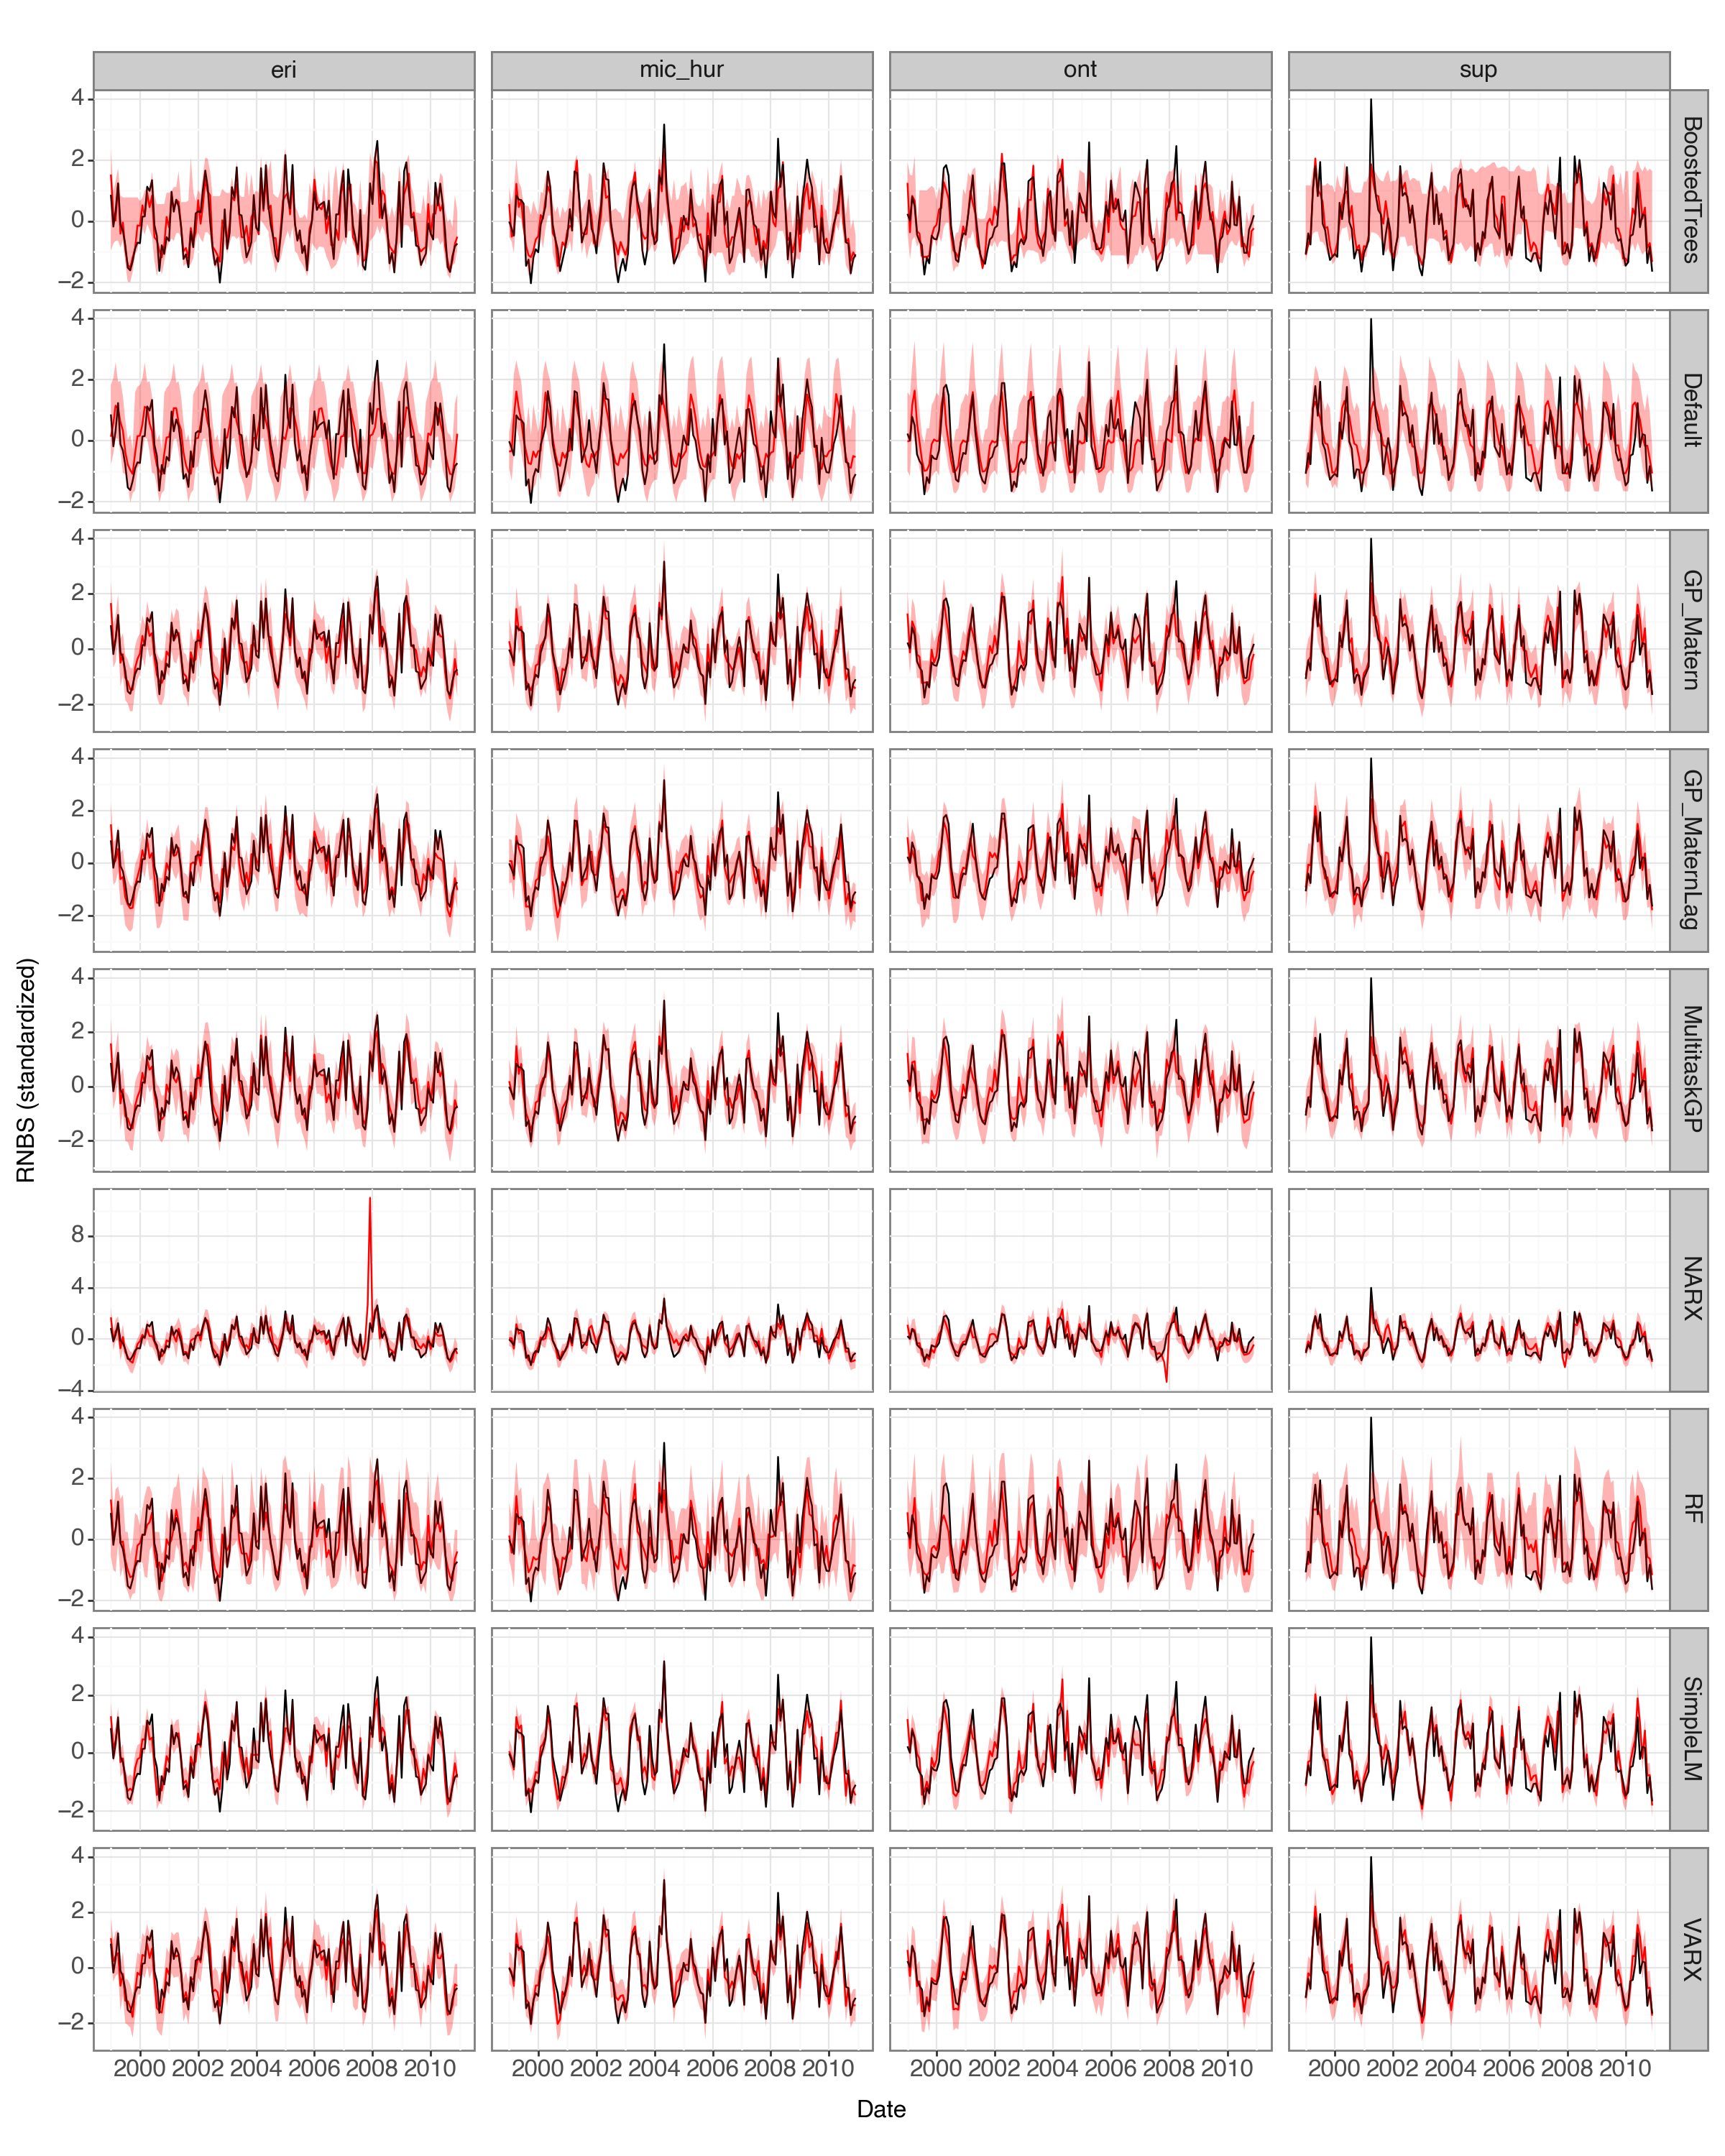

<Figure Size: (1200 x 1500)>

In [12]:
import warnings

warnings.filterwarnings("ignore")

plot_data = cv_results.reset_index()
# plot_data = plot_data[plot_data["model"].isin(["Default", "GP_Matern", "MultitaskGP", "NARX", "VARX"])]
(
        ggplot(data=plot_data.reset_index(), mapping=aes(x="Date", y="mean"))
        + geom_line(color="red")
        + geom_line(mapping=aes(x="Date", y="true"), color="black")
        + facet_grid("model~lake", scales="free_y")
        + scale_x_datetime(
    limits=[plot_data.Date.min(), plot_data.Date.max()],
    labels=date_format(fmt="%Y"), breaks=date_breaks("2 year"))
        + geom_ribbon(
    mapping=aes(x="Date", ymin="lower", ymax="upper"), fill="red", alpha=0.3,
) + ylab("RNBS (standardized)")
        + theme_bw()
        + theme(text=element_text(size=12), figure_size=(12, 15))
)


In [15]:
model = varx_models["VARX"].steps[-1][1]
summarized = az.summary(model.trace, filter_vars="regex", var_names=["alpha"])

summarized[~((summarized["hdi_3%"] <= 0) & (summarized["hdi_97%"] >= 0))]

mean     sd  hdi_3%  hdi_97%  mcse_mean  \
evap_alpha[sup, eri]         -0.218  0.041  -0.296   -0.141      0.001   
evap_alpha[sup, ont]         -0.189  0.091  -0.359   -0.018      0.001   
evap_alpha[mic_hur, eri]     -0.086  0.038  -0.153   -0.013      0.001   
evap_alpha[mic_hur, ont]     -0.443  0.086  -0.606   -0.288      0.001   
evap_alpha[eri, ont]         -0.265  0.108  -0.470   -0.064      0.002   
evap_alpha[ont, ont]         -0.281  0.098  -0.462   -0.100      0.002   
precip_alpha[sup, mic_hur]   -0.066  0.029  -0.120   -0.009      0.000   
precip_alpha[sup, eri]        0.433  0.027   0.379    0.478      0.000   
precip_alpha[mic_hur, eri]   -0.063  0.024  -0.107   -0.015      0.000   
precip_alpha[mic_hur, ont]    0.566  0.029   0.514    0.623      0.000   
precip_alpha[eri, sup]        0.500  0.044   0.422    0.587      0.001   
precip_alpha[eri, mic_hur]    0.085  0.037   0.013    0.151      0.001   
precip_alpha[eri, eri]       -0.056  0.030  -0.112   -0.001      0.000   
precip_alpha[ont, mic_hur]    0.493  0.033   0.429    0.554      0.000   
temp_alpha[sup, eri]         -0.492  0.216  -0.886   -0.084      0.003   
y_alpha[sup, sup, 3]          0.103  0.033   0.040    0.163      0.000   
y_alpha[mic_hur, mic_hur, 3]  0.119  0.037   0.048    0.185      0.001   
y_alpha[mic_hur, eri, 3]      0.105  0.037   0.037    0.177      0.001   
y_alpha[ont, eri, 3]          0.086  0.042   0.007    0.166      0.001   
y_alpha[ont, ont, 3]          0.209  0.046   0.127    0.300      0.001   

                              mcse_sd  ess_bulk  ess_tail  r_hat  
evap_alpha[sup, eri]            0.000    6040.0    3112.0    1.0  
evap_alpha[sup, ont]            0.001    6309.0    3193.0    1.0  
evap_alpha[mic_hur, eri]        0.000    4433.0    3490.0    1.0  
evap_alpha[mic_hur, ont]        0.001    4761.0    2994.0    1.0  
evap_alpha[eri, ont]            0.001    4895.0    3289.0    1.0  
evap_alpha[ont, ont]            0.001    4206.0    3397.0    1.0  
precip_alpha[sup, mic_hur]      0.000    5815.0    2599.0    1.0  
precip_alpha[sup, eri]          0.000    7128.0    3018.0    1.0  
precip_alpha[mic_hur, eri]      0.000    6311.0    3421.0    1.0  
precip_alpha[mic_hur, ont]      0.000    5122.0    3519.0    1.0  
precip_alpha[eri, sup]          0.000    4391.0    3467.0    1.0  
precip_alpha[eri, mic_hur]      0.000    5184.0    3248.0    1.0  
precip_alpha[eri, eri]          0.000    6241.0    3108.0    1.0  
precip_alpha[ont, mic_hur]      0.000    5137.0    3192.0    1.0  
temp_alpha[sup, eri]            0.002    6847.0    3042.0    1.0  
y_alpha[sup, sup, 3]            0.000    6684.0    3540.0    1.0  
y_alpha[mic_hur, mic_hur, 3]    0.000    4796.0    2935.0    1.0  
y_alpha[mic_hur, eri, 3]        0.000    5156.0    3781.0    1.0  
y_alpha[ont, eri, 3]            0.000    4475.0    3389.0    1.0  
y_alpha[ont, ont, 3]            0.000    5032.0    3331.0    1.0

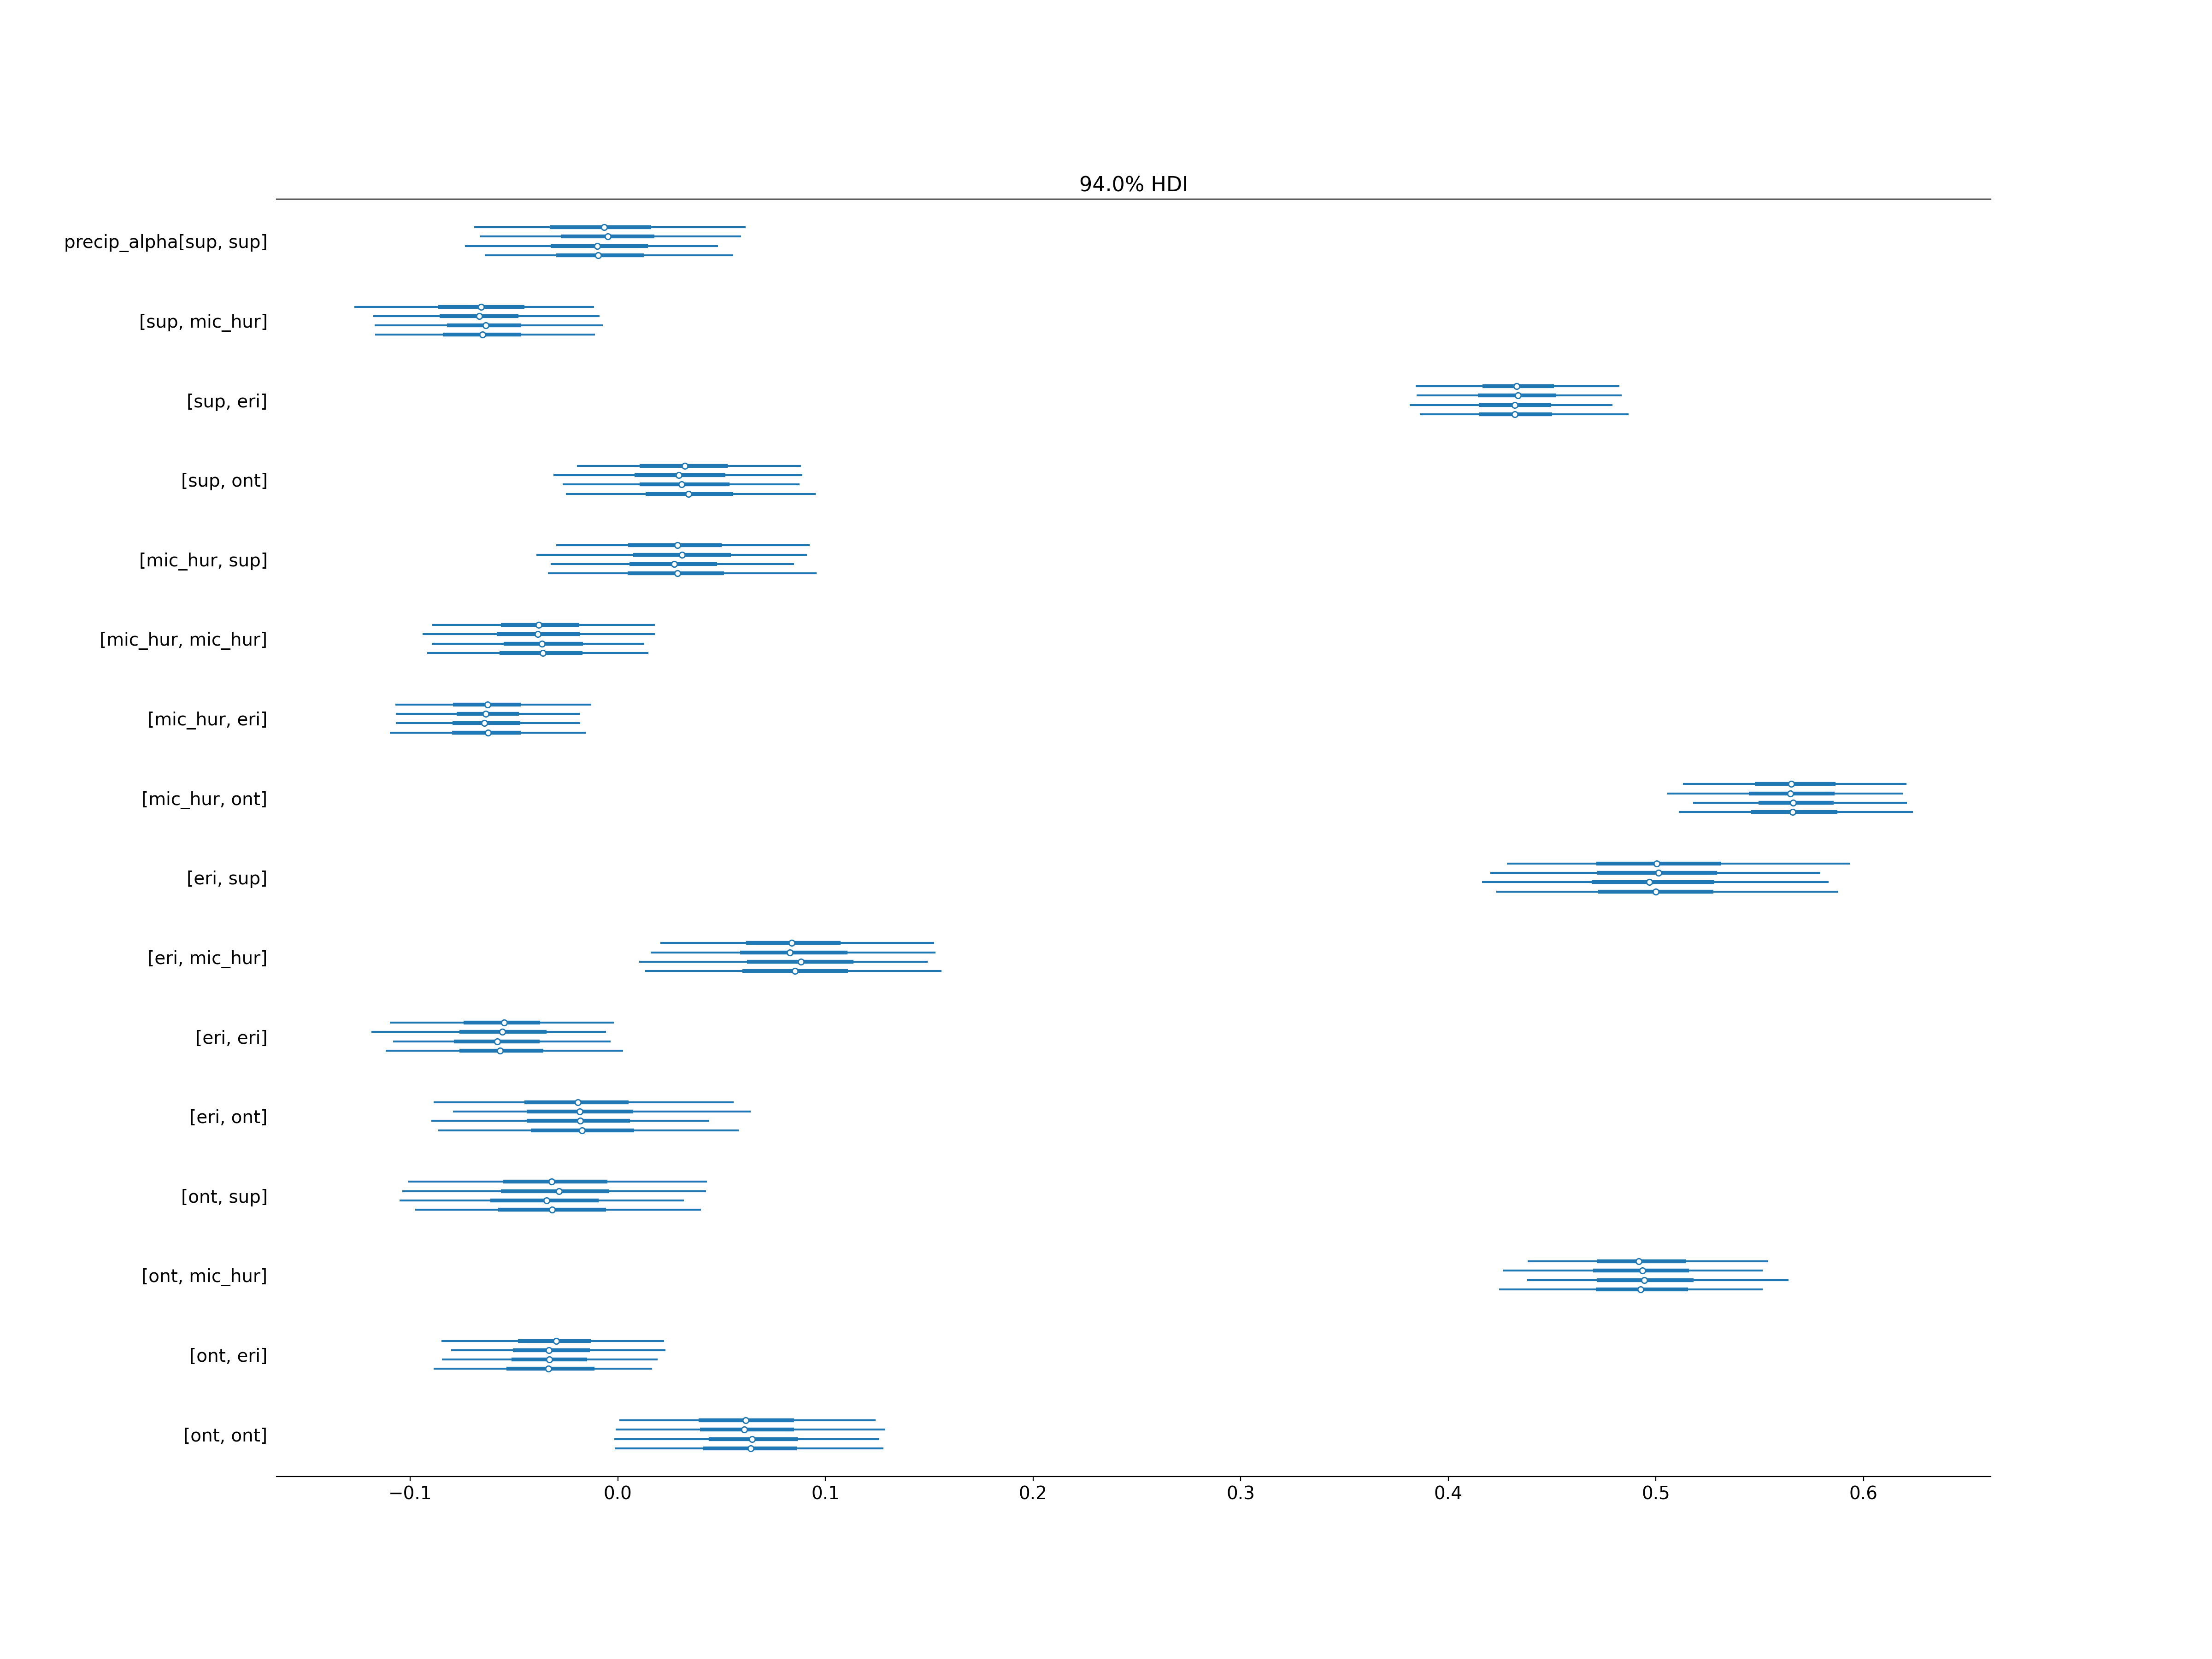

In [17]:
az.plot_forest(model.trace, var_names=["precip"], filter_vars="regex", figsize=(24, 18))

plt.show()

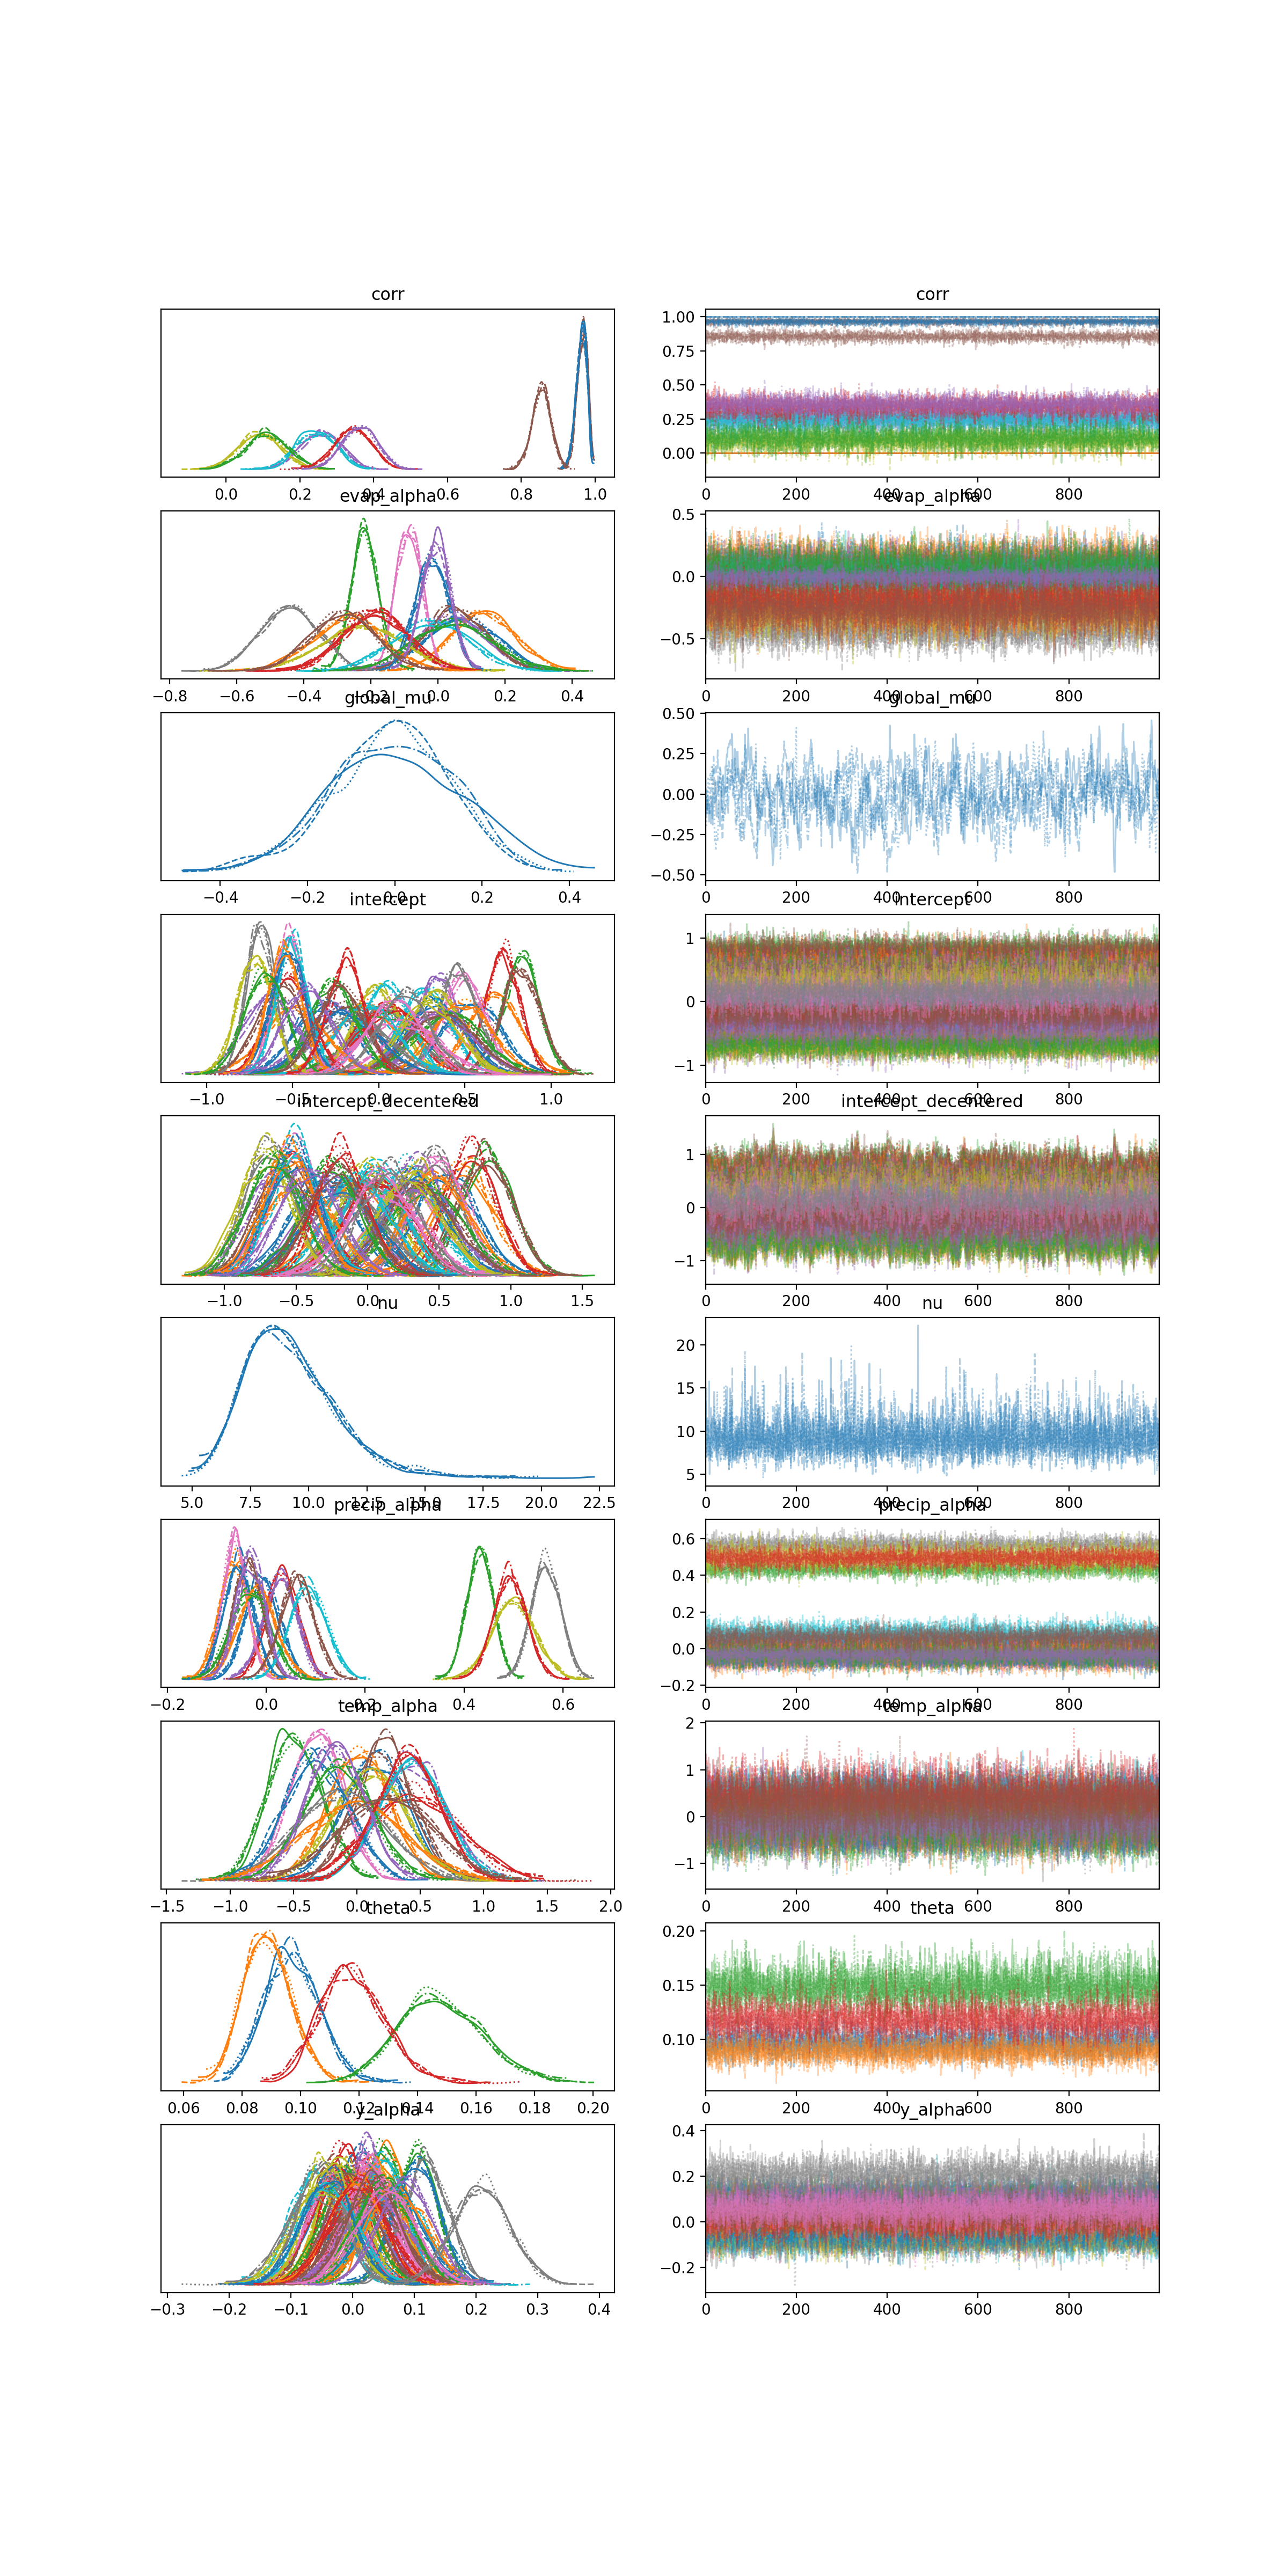

In [20]:
az.plot_trace(model.trace, figsize=(12, 24))
plt.show()